In [125]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, MiniBatchSparsePCA, TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN, MeanShift, OPTICS, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
import scipy.cluster.hierarchy as sch
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

In [3]:
df = pd.read_pickle('FT-data-DSpace/data_agreggated.pickle')
df = df[['Date', 'Meeting Number', 'Clean']]

In [4]:
df['Sentences'] = df['Clean'].apply(lambda x: ' '.join(x))
df['Date'] = pd.to_datetime(df['Date'])
df.sample(2)

,Date,Meeting Number,Clean,Sentences
457,2013-11-22 10:00:00,22. møde,"[mød, åbn, statsminist, modtag, brev, eft, sta...",mød åbn statsminist modtag brev eft statsminis...
362,2013-01-15 13:00:00,42. møde,"[mød, åbn, dag, følg, anmeld, udenrigsminist, ...",mød åbn dag følg anmeld udenrigsminist villy s...


In [5]:
#tvec = TfidfVectorizer(min_df=.01, max_df=1.0, sublinear_tf=True, analyzer='word', ngram_range=(1,2), max_features=20000)
tvec = TfidfVectorizer(analyzer='word', ngram_range=(1,1), max_features=10000,  
                       min_df=10, max_df=0.7, sublinear_tf=True)
x = tvec.fit_transform(df['Sentences'])

words = tvec.get_feature_names()

In [6]:
df_x = pd.DataFrame(columns= words, data=x.toarray())
df_x['Date'] = df['Date']
df_x['Year'] = df_x['Date'].dt.year
df_x['Meeting'] = df['Meeting Number']
df_x.sample(2)

,3f,a4,aabenraa,aaen,aaja,aalborg,aamund,aarhus,aastrup,abba,...,østjylland,østjysk,østr,østrigsk,øve,øvels,øverst,Date,Year,Meeting
601,0.000000,0.0,0.0,0.040383,0.0,0.0,0.000000,0.0,0.031313,0.0,...,0.0,0.027095,0.00000,0.0,0.0,0.000000,0.013114,2015-02-19 10:00:00,2015,57. møde
212,0.017237,0.0,0.0,0.000000,0.0,0.0,0.054264,0.0,0.000000,0.0,...,0.0,0.000000,0.01846,0.0,0.0,0.012195,0.000000,2011-06-01 09:00:00,2011,104. møde


### PCA

Performing dimensionality reduction using LSA
done in 62.003071s


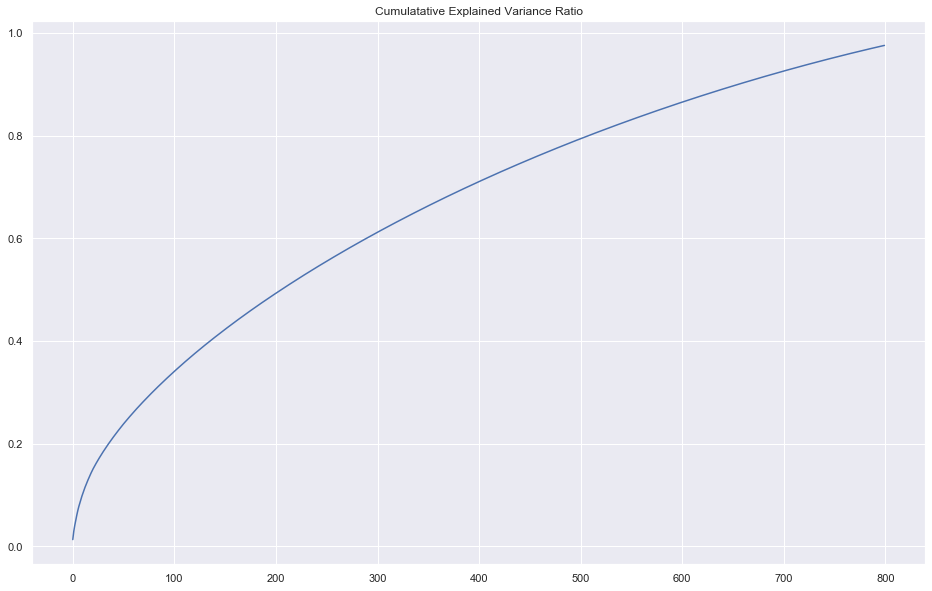

In [8]:
print("Performing dimensionality reduction using LSA")
t0 = time.time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components=800, n_iter=100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

pca_result = lsa.fit_transform(df_x[words])
df_x['pca-one'] = pca_result[:,0]
df_x['pca-two'] = pca_result[:,1] 
df_x['pca-three'] = pca_result[:,2]#

print("done in %fs" % (time.time() - t0))
plt.figure(figsize=(16,10))
plt.title('Cumulatative Explained Variance Ratio')
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.show()

In [ ]:
#pca = TruncatedSVD(n_components=700, n_iter=10) ## latent semantic analysis (LSA)
#pca_result = pca.fit_transform(df_x[words].values)
#pca_result = normalize(pca_result)
#df_x['pca-one'] = pca_result[:,0]
#df_x['pca-two'] = pca_result[:,1] 
#df_x['pca-three'] = pca_result[:,2]#


### K-means clustering 

In [88]:
### you can skip the elbow method

In [89]:

clustering = KMeans(n_clusters=20, n_init=30, max_iter=2000, algorithm='full').fit(pca_result)
df_x['label'] = clustering.labels_

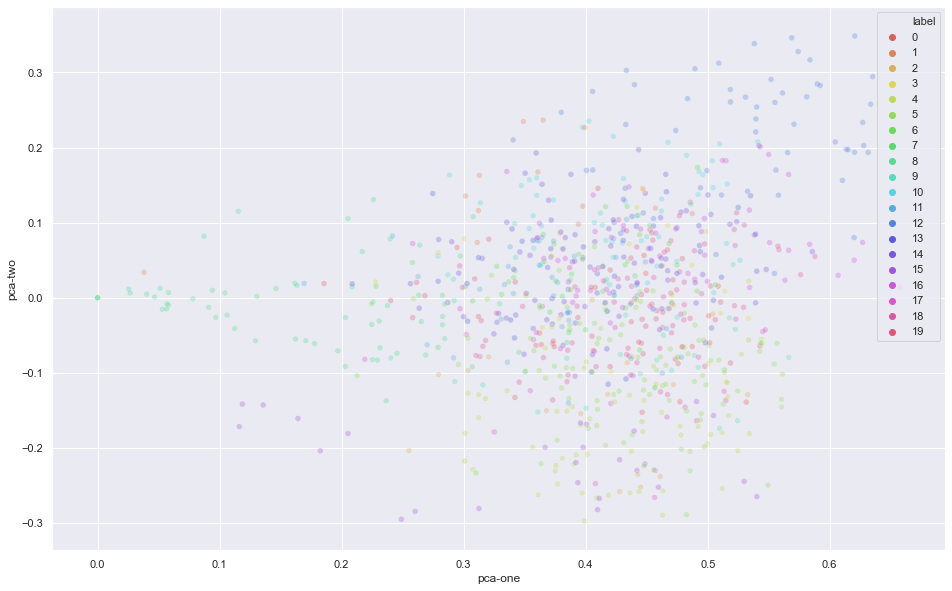

In [90]:

clustering = KMeans(n_clusters=20, n_init=30, max_iter=2000, algorithm='full').fit(pca_result)
df_x['label'] = clustering.labels_

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", np.max(clustering.labels_)+1),
    data=df_x,
    legend="full",
    alpha=0.3
)

In [91]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
#tsne_results = tsne.fit_transform(df_x[words])
tsne_results = tsne.fit_transform(pca_result)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.082s...
[t-SNE] Computed neighbors for 863 samples in 0.874s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.352866
[t-SNE] KL divergence after 250 iterations with early exaggeration: 178.208008
[t-SNE] KL divergence after 1000 iterations: 3.739277
t-SNE done! Time elapsed: 4.7493321895599365 seconds


In [92]:
df_x['tsne_component_one'] = tsne_results[:,0]
df_x['tsne_component_two'] = tsne_results[:,1]

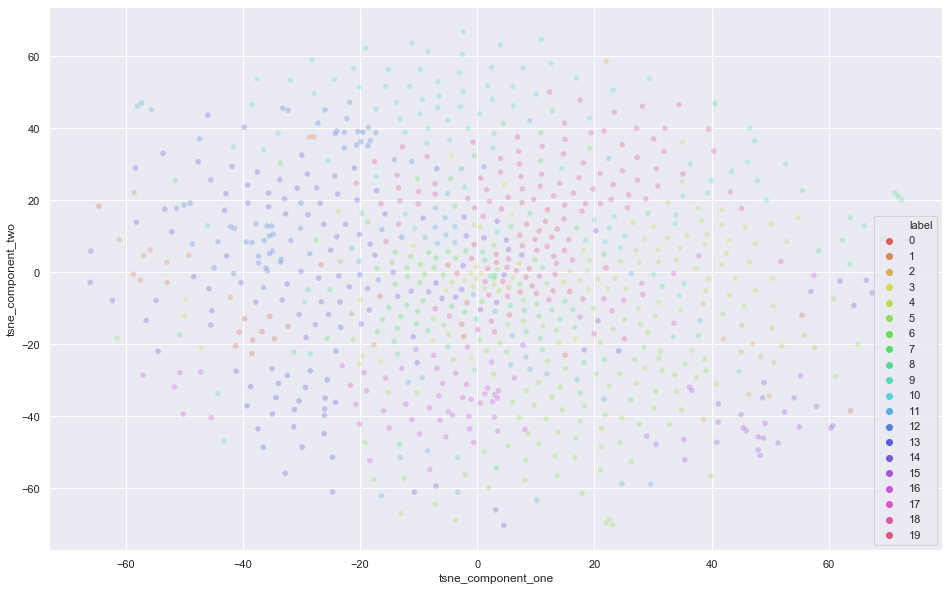

In [93]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_component_one", y="tsne_component_two",
    hue='label',
    palette=sns.color_palette("hls", np.max(clustering.labels_)+1),
    data=df_x,
    legend="full",
    alpha=0.3
)

<Figure size 1152x720 with 0 Axes>

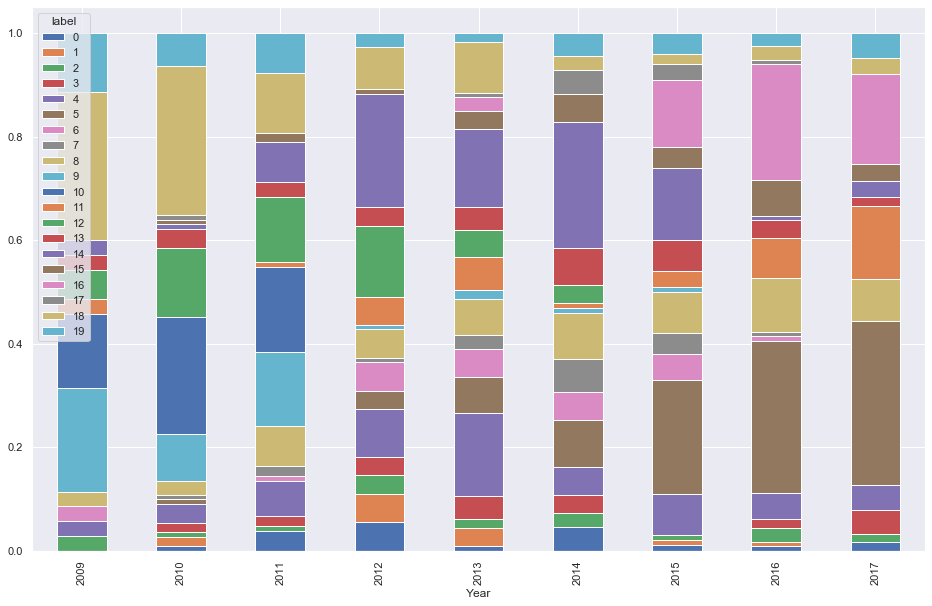

In [94]:
plt.figure(figsize=(16,10))
df_ = df_x.groupby(['Year', 'label'])['Meeting'].count().unstack()
df_ = df_.div(df_.sum(axis=1),axis=0).plot(kind='bar', stacked=True,  figsize=(16,10))
plt.show()

In [95]:
original_space_centroids = svd.inverse_transform(clustering.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tvec.get_feature_names()
for i in range(np.max(clustering.labels_)+1):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: euroland euro finanspag folkeafstemning euroforbehold eurozon adelste villums suverænit traktat
Cluster 1: akutjob dagpengeperiod dagpengesystem dagpengereform dagpengeret dagpeng beskæftigelsesminist jobpræmi bøgsted akutpak
Cluster 2: israel palæstinensisk palæstina israelsk tostatsløsning palæstinens vestbred udenrigsminist gaza mellemøst
Cluster 3: ressourceforløb fleksjob bøgsted offentlighedslov sørens aktinds bent offentlighedskommission førtidspension beskæftigelsesminist
Cluster 4: justitsminist politi forbryd behnk fængsel kriminalit kriminel straffelovråd retsudvalg straf
Cluster 5: flygtning integration asylansøg asyl udlænding grønland martin niels knuth marcus
Cluster 6: landdistrik udlej byforny dohn bol by landdistriktsminist yderområd lejelov byer
Cluster 7: dsb jernban transportminist togdrift pihl ic4 togfond strækning skattecentr elektrificering
Cluster 8: onsdag ændringsforslag nyvalg kf la rv udvalgsbehandling oktob august forretningsorden
Cluster 9: ba

### Agglomerative Clustering

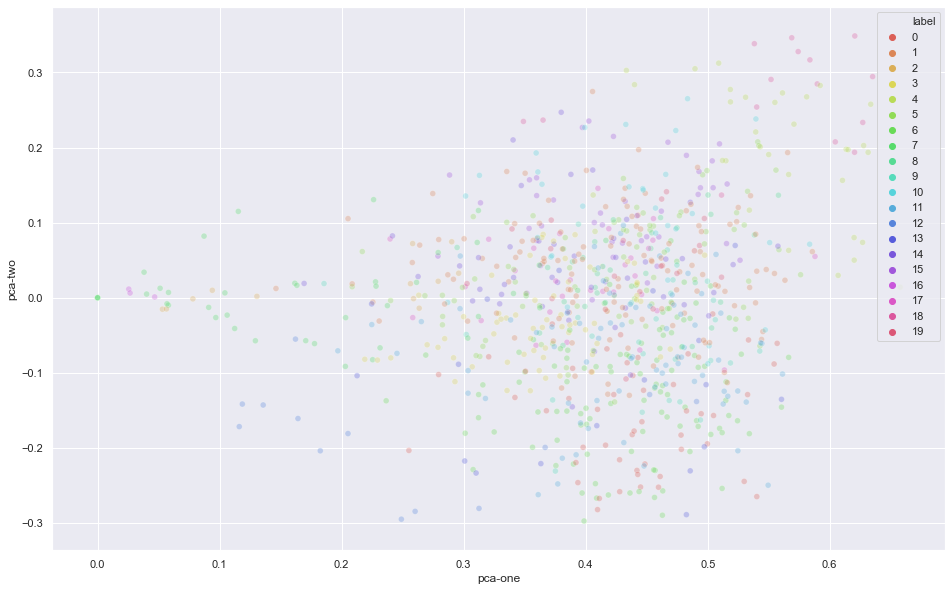

In [124]:

clustering = AgglomerativeClustering(n_clusters=20, compute_full_tree=True).fit(pca_result)
df_x['label'] = clustering.labels_

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", np.max(clustering.labels_)+1),
    data=df_x,
    legend="full",
    alpha=0.3
)

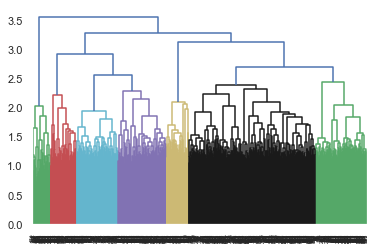

In [128]:
dendrogram = sch.dendrogram(sch.linkage(pca_result, method='ward'))

### Archive

In [ ]:
#Code For Elbow Method
nc = range(40,70,5)
kmeans = [KMeans(n_clusters = i, n_init = 10, max_iter = 100, algorithm='full') for i in nc]
score = [kmeans[i].fit(pca_result).inertia_ for i in range(len(kmeans))]
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show() ## to find the most optimal K -> optimal K is when the graph levels off


In [60]:
k = 10
#kmeans = KMeans(n_clusters=3).fit(df_x[words])
kmeans = KMeans(n_clusters=k, n_init=10, max_iter=2000, algorithm='full').fit(pca_result)
df_x['label'] = kmeans.labels_

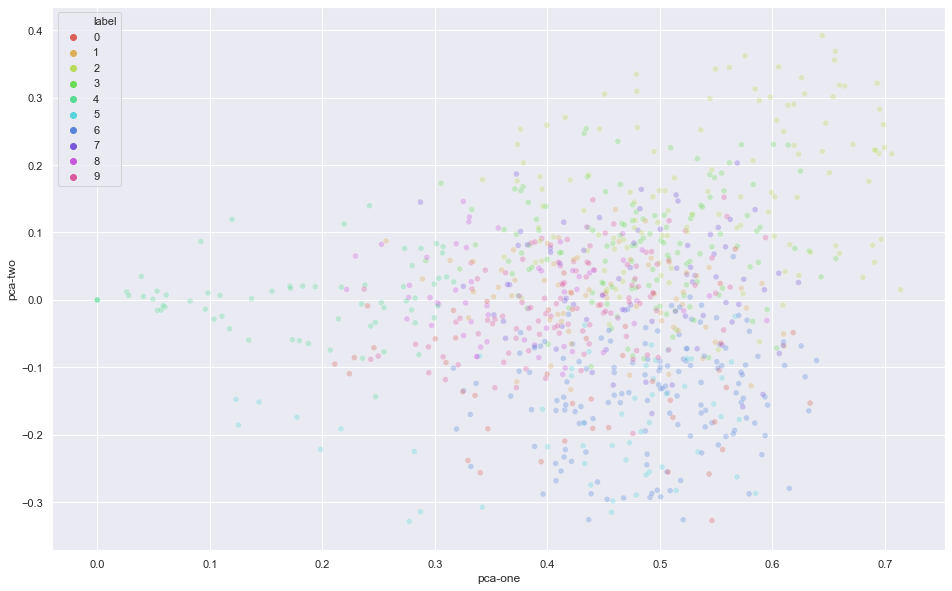

In [61]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

#### T-SNE

In [62]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
#tsne_results = tsne.fit_transform(df_x[words])
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.086s...
[t-SNE] Computed neighbors for 863 samples in 0.608s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.295880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 159.161560
[t-SNE] KL divergence after 1000 iterations: 3.105813
t-SNE done! Time elapsed: 4.813013553619385 seconds


In [63]:
df_x['tsne_component_one'] = tsne_results[:,0]
df_x['tsne_component_two'] = tsne_results[:,1]

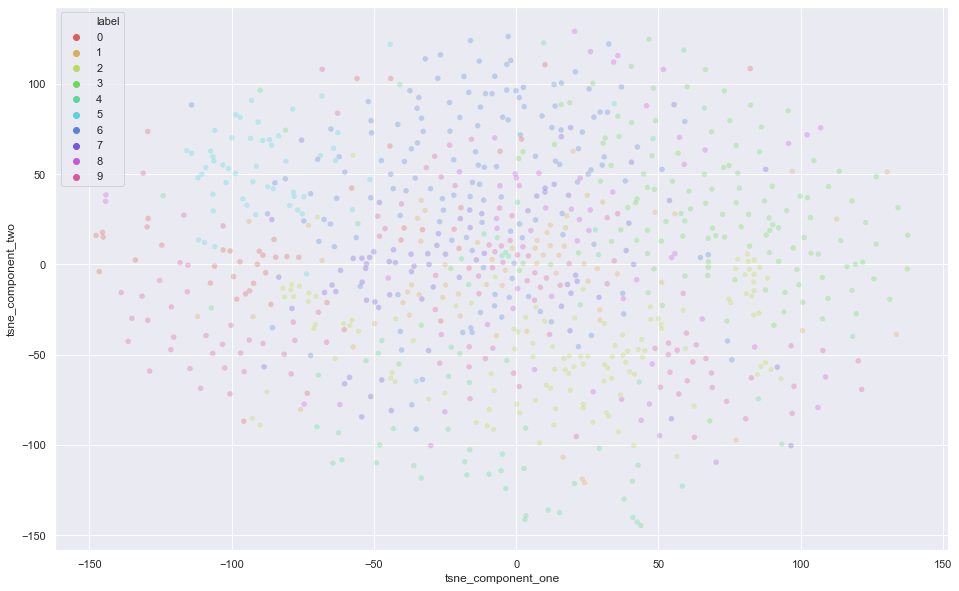

In [64]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_component_one", y="tsne_component_two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

<Figure size 1152x720 with 0 Axes>

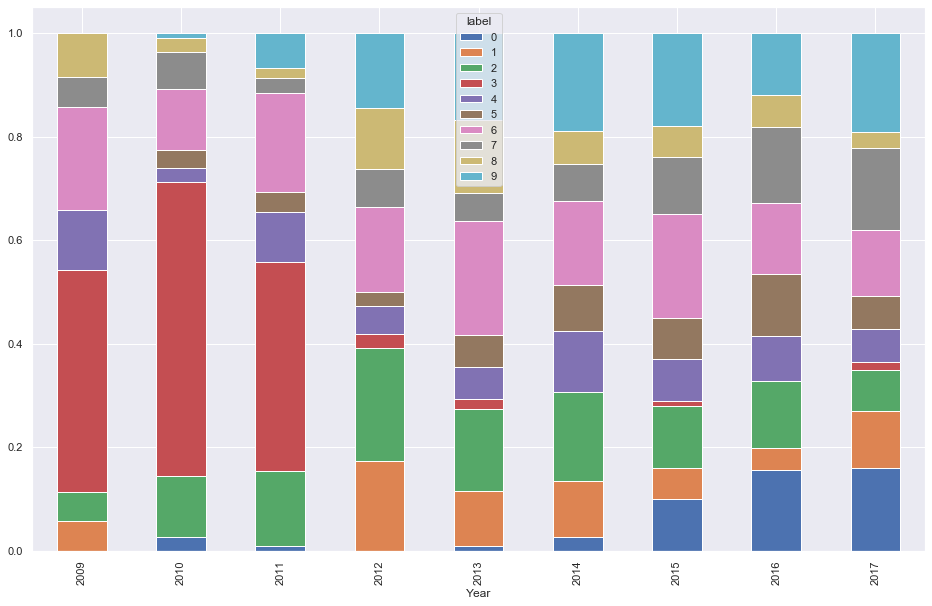

In [65]:
plt.figure(figsize=(16,10))
df_ = df_x.groupby(['Year', 'label'])['Meeting'].count().unstack()
df_ = df_.div(df_.sum(axis=1),axis=0).plot(kind='bar', stacked=True,  figsize=(16,10))
plt.show()

In [67]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tvec.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: flygtning asylansøg knuth marcus asyl integration johan integrationsyd sofi opholdstillad
Cluster 1: elev folkeskol undervisning ahrendts alex forældr rosa meret riisag dohn
Cluster 2: arbejdsløs skattelet dagpeng kontanthjælp reform skattereform dagpengeperiod dagpengesystem oles forsørg
Cluster 3: barfod lausts per anders lin bjarn indenr region sundhedsminist sophi
Cluster 4: onsdag kong ændringsforslag oktob nyvalg august grønland færø kf udvalgsbehandling
Cluster 5: udenrigsminist militær isil irak syri fn civil soldat nato krig
Cluster 6: justitsminist politi kriminalit kriminel domstol forbryd straf forslagsstil behnk fængsel
Cluster 7: co2 fossil omstilling energi pso vedvar grøn energipolitik udledning klima
Cluster 8: patient sundhedsvæs sundhedsvæsen sundhedsstyr region sophi sygdom ændringsforslag sundhedsminist blixt
Cluster 9: medspørg justitsminist transportminist politi oplæsning skatteminist finansminist pet skaarup spørgetid


In [68]:
#### make per meeting agenda